## Handwritten Digit Recognition

### Data Prep, Training and Evaluation

In [13]:
import numpy as np
import cv2

# Let's take a look at our digits dataset
image = cv2.imread('images/digits.png')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
small = cv2.pyrDown(image)
cv2.imshow('Digits Image', small)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Split the image to 5000 cells, each 20x20 size
# This gives us a 4-dim array: 50 x 100 x 20 x 20
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Convert the List data type to Numpy Array of shape (50,100,20,20)
x = np.array(cells)
print ("The shape of our cells array: " + str(x.shape))

# Split the full data set into two segments
# One will be used fro Training the model, the other as a test data set
train = x[:,:70].reshape(-1,400).astype(np.float32) # Size = (3500,400)
test = x[:,70:100].reshape(-1,400).astype(np.float32) # Size = (1500,400)

# Create labels for train and test data
k = [0,1,2,3,4,5,6,7,8,9]
train_labels = np.repeat(k,350)[:,np.newaxis]
test_labels = np.repeat(k,150)[:,np.newaxis]

# Initiate kNN, train the data, then test it with test data for k=3
knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)
ret, result, neighbors, distance = knn.findNearest(test, k=3)

# Now we check the accuracy of classification
# For that, compare the result with test_labels and check which are wrong
matches = result == test_labels
correct = np.count_nonzero(matches)
accuracy = correct * (100.0 / result.size)
print("Accuracy is = %.2f" % accuracy + "%")


The shape of our cells array: (50, 100, 20, 20)
Accuracy is = 93.47%


### Defining some functions we will use to prepare an input image

In [14]:
import numpy as np
import cv2

# Define our functions

def x_cord_contour(contour):
    # This function take a contour from findContours
    # it then outputs the x centroid coordinates
    M = cv2.moments(contour)
    return (int(M['m10']/M['m00']))

def makeSquare(not_square):
    # This function takes an image and makes the dimenions square
    # It adds black pixels as the padding where needed
    
    BLACK = [0,0,0]
    img_dim = not_square.shape
    height = img_dim[0]
    width = img_dim[1]
    #print("Height = ", height, "Width = ", width)
    if (height == width):
        square = not_square
        return square
    else:
        doublesize = cv2.resize(not_square,(2*width, 2*height), interpolation = cv2.INTER_CUBIC)
        height = height * 2
        width = width * 2
        #print("New Height = ", height, "New Width = ", width)
        if (height > width):
            pad = int((height - width)/2)
            #print("Padding = ", pad)
            doublesize_square = cv2.copyMakeBorder(doublesize,0,0,pad, pad,cv2.BORDER_CONSTANT,value=BLACK)
        else:
            pad = int((width - height)/2)
            #print("Padding = ", pad)
            doublesize_square = cv2.copyMakeBorder(doublesize,pad,pad,0,0, cv2.BORDER_CONSTANT,value=BLACK)
    doublesize_square_dim = doublesize_square.shape
    #print("Sq Height = ", doublesize_square_dim[0], "Sq Width = ", doublesize_square_dim[1])
    return doublesize_square


def resize_to_pixel(dimensions, image):
    # This function then re-sizes an image to the specificied dimensions
    
    buffer_pix = 4
    dimensions  = dimensions - buffer_pix
    squared = image
    r = float(dimensions) / squared.shape[1]
    dim = (dimensions, int(squared.shape[0] * r))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    img_dim2 = resized.shape
    height_r = img_dim2[0]
    width_r = img_dim2[1]
    BLACK = [0,0,0]
    if (height_r > width_r):
        resized = cv2.copyMakeBorder(resized,0,0,0,1,cv2.BORDER_CONSTANT,value=BLACK)
    if (height_r < width_r):
        resized = cv2.copyMakeBorder(resized,1,0,0,0,cv2.BORDER_CONSTANT,value=BLACK)
    p = 2
    ReSizedImg = cv2.copyMakeBorder(resized,p,p,p,p,cv2.BORDER_CONSTANT,value=BLACK)
    img_dim = ReSizedImg.shape
    height = img_dim[0]
    width = img_dim[1]
    #print("Padded Height = ", height, "Width = ", width)
    return ReSizedImg

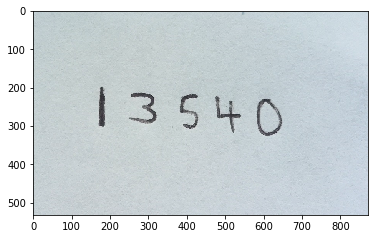

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image)

## Loading a new image, preprocessing it and classifying the digits

In [16]:
import numpy as np
import cv2


image = cv2.imread('images/numbers.jpg')

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2.imshow("image", image)
cv2.imshow("gray", gray)
cv2.waitKey(0)

# Blur image then find edges using Canny 
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
cv2.imshow("blurred", blurred)
cv2.waitKey(0)

edged = cv2.Canny(blurred, 30, 170)
cv2.imshow("edged", edged)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Fint Contours
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Sort out contours left to right by using their x cordinates
contours = sorted(contours, key = x_cord_contour, reverse = False)

# Create empty array to store entire number
full_number = []

# loop over the contours
for c in contours:
    # compute the bounding box for the rectangle
    (x, y, w, h) = cv2.boundingRect(c)    
    
#     cv2.drawContours(image, contours, -1, (0,255,0), 3)
#     cv2.imshow("Contours", image)

    if w >= 5 and h >= 25:
        roi = blurred[y:y + h, x:x + w]
        ret, roi = cv2.threshold(roi, 127, 255,cv2.THRESH_BINARY_INV)
        squared = makeSquare(roi)
        final = resize_to_pixel(20, squared)
        cv2.imshow("final", final)
        final_array = final.reshape((1,400))
        final_array = final_array.astype(np.float32)
        ret, result, neighbours, dist = knn.findNearest(final_array, k=1)
        number = str(int(float(result[0])))
        full_number.append(number)
        # draw a rectangle around the digit, the show what the
        # digit was classified as
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(image, number, (x , y + 155),
            cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 0), 2)
        cv2.imshow("image", image)
        cv2.waitKey(0) 
        
cv2.destroyAllWindows()
print ("The number is: " + ''.join(full_number))

The number is: 13540


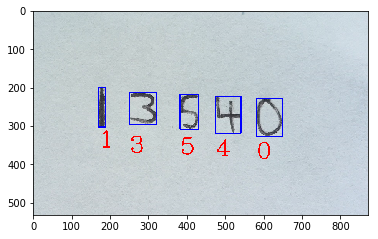

In [17]:
plt.imshow(image)